In [1]:
import pathlib, pickle
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import percentileofscore, kstest, randint, chisquare
from scipy.spatial.distance import mahalanobis
from tqdm import tqdm
from elyawy.sparta import Msa, Simulator
from elyawy.constants import SUMSTATS_LIST
from sim_creator import SimConfig
import realigner as rl


In [2]:
WORKING_DIR = pathlib.Path.home() / "Data/adequacy_experiments"
pathlib.Path.home()
WORKING_DIR.exists()

True

In [3]:
CURRENT_EXPERIMENT = "experiment_3"

In [4]:
TREE_PATH = None
if len( n := list((WORKING_DIR/ CURRENT_EXPERIMENT).glob("*.tree"))) == 1:
    TREE_PATH = n[0]
TREE_PATH
sim = Simulator(TREE_PATH)


In [5]:
np.random.seed(200)
param_generator = SimConfig()
empirical_params = param_generator.get_random_sim(1)[0]
NUM_EMPIRICAL_PARAMS = 1000

empirical_params

array([378, 0.01906189684526892, 0.01906189684526892, 'zipf',
       2.031245104010394, 2.031245104010394], dtype=object)

In [6]:
def empirical_p_values(stats_list, empirical_stat, n):
    r1 = sum(stats_list >= empirical_stat)
    p1 = (r1+1)/(n+1)
    # r2 = sum(stats_list <= empirical_stat)
    # p2 = (r2+1)/(n+1)
    # p = 2*min(p1,p2)

    return p1

In [7]:
# sim.set_seed(42)
#EXPERIMENT 1:
NUMBER_OF_SAMPLES = 1000
sim_msas_stats = np.zeros(shape=(NUMBER_OF_SAMPLES,27))
pvals = np.zeros(shape=(NUM_EMPIRICAL_PARAMS,27))

sim.init_sim(*empirical_params)

for pidx in tqdm(range(NUM_EMPIRICAL_PARAMS)):
    true_msa_stats = np.array(sim().get_sum_stats())

    for i in range(NUMBER_OF_SAMPLES):
        sim_msas_stats[i,:] = sim().get_sum_stats()
    
    for idx,stat in enumerate(SUMSTATS_LIST):
        p_val_x = empirical_p_values(sim_msas_stats.T[idx], true_msa_stats[idx], n=NUMBER_OF_SAMPLES)
        pvals[pidx,idx] = p_val_x


experiment_1_pvals = pvals.copy()

100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


In [8]:
rejections_1 = sum(experiment_1_pvals < 0.05)/NUM_EMPIRICAL_PARAMS
for i,j in zip(rejections_1, SUMSTATS_LIST):
    print(f"{j}: {i:.1%}")

SS_0: 4.4%
SS_1: 3.6%
SS_2: 4.8%
SS_3: 3.3%
SS_4: 3.0%
SS_5: 5.7%
SS_6: 4.2%
SS_7: 3.6%
SS_8: 3.6%
SS_9: 3.3%
SS_10: 3.4%
SS_11: 3.7%
SS_12: 2.2%
SS_13: 3.4%
SS_14: 2.7%
SS_15: 2.6%
SS_16: 3.7%
SS_17: 3.3%
SS_18: 1.3%
SS_19: 3.5%
SS_20: 2.9%
SS_21: 2.0%
SS_22: 3.2%
SS_23: 4.1%
SS_24: 3.7%
SS_25: 4.7%
SS_26: 4.7%


In [9]:
sum((experiment_1_pvals < 0.05/27).sum(axis=0))

11

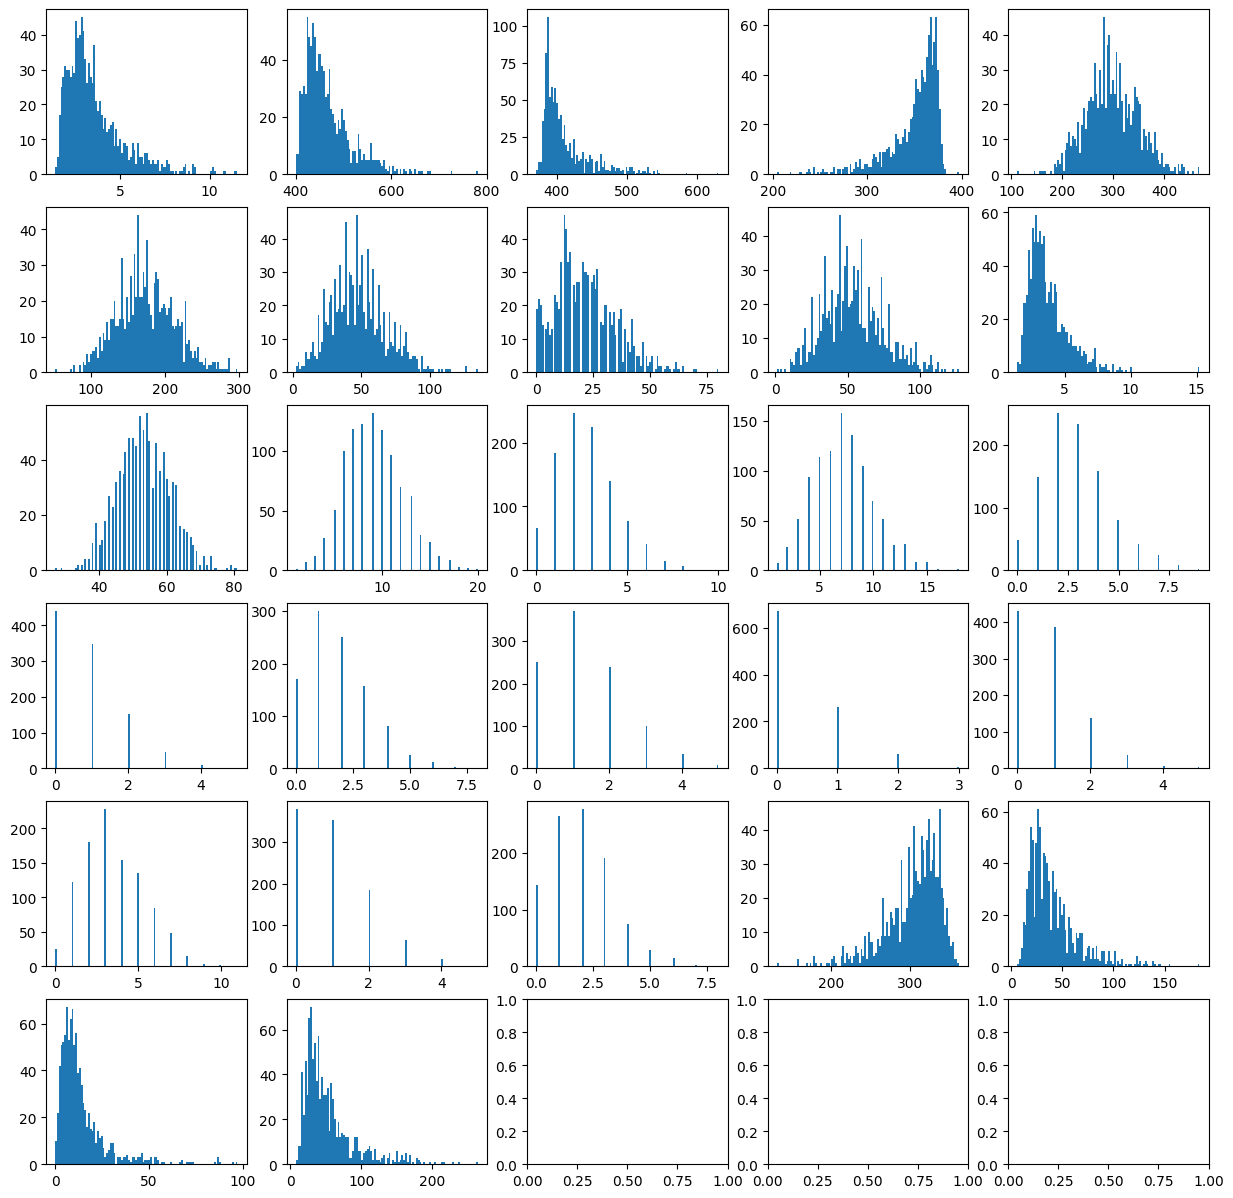

In [10]:
fig, axs = plt.subplots(6,5)
fig.set_size_inches(w=15, h=15)

axs = axs.flatten()

for i in range(27):
    axs[i].hist(sim_msas_stats.T[i], bins=100)
plt.show()

In [11]:
#EXPERIMENT 2:
NUMBER_ABC_SIMS = 100000
ABC_THRESHOLD = 100
NUMBER_OF_SAMPLES = 1000

sim_msas_abc = np.zeros(shape=(NUMBER_ABC_SIMS,27))

sim_msas_stats = np.zeros(shape=(NUMBER_OF_SAMPLES,27))
pvals = np.zeros(shape=(NUM_EMPIRICAL_PARAMS,27))


sim_params = param_generator.get_random_sim(NUMBER_ABC_SIMS)
sim_params.shape


(100000, 6)

In [12]:

for i,params in enumerate(sim_params):
    sim.init_sim(*params)
    sim_msa = sim()
    sim_msas_abc[i,:] = sim_msa.get_sum_stats()

print("finished simulating")

cov = np.cov(sim_msas_abc.T)
cov = cov + np.eye(len(cov))*1e-4
inv_covmat = np.linalg.inv(cov)




finished simulating


In [13]:

for pidx in tqdm(range(NUM_EMPIRICAL_PARAMS)):
    sim.init_sim(*empirical_params)
    true_msa = sim()
    true_msa_stats = np.array(true_msa.get_sum_stats())

    u_minus_v = true_msa_stats-sim_msas_abc
    left = np.dot(u_minus_v, inv_covmat)
    all_distances = np.sqrt(np.sum(u_minus_v*left, axis=1))
    
    
    top_indexes = np.argpartition(all_distances, ABC_THRESHOLD)[:ABC_THRESHOLD]
    sampled_indx = np.random.choice(top_indexes, size=NUMBER_OF_SAMPLES)
    sampled_params = sim_params[sampled_indx]
    
    for i,params_sim in enumerate(sampled_params):
        sim.init_sim(*params_sim)
        sim_msa = sim()

        sim_msas_stats[i,:] = sim_msa.get_sum_stats()
    
    for idx,stat in enumerate(SUMSTATS_LIST):
        p_val_x = empirical_p_values(sim_msas_stats.T[idx], true_msa_stats[idx], n=NUMBER_OF_SAMPLES)
        pvals[pidx,idx] = p_val_x


experiment_2_pvals = pvals.copy()

100%|██████████| 1000/1000 [06:25<00:00,  2.59it/s]


In [14]:
rejections_2 = sum(experiment_2_pvals < 0.05)/NUM_EMPIRICAL_PARAMS
for i,j in zip(rejections_2, SUMSTATS_LIST):
    print(f"{j}: {i:.1%}")

SS_0: 0.0%
SS_1: 0.1%
SS_2: 0.4%
SS_3: 0.2%
SS_4: 0.1%
SS_5: 3.6%
SS_6: 7.5%
SS_7: 6.3%
SS_8: 0.0%
SS_9: 0.0%
SS_10: 0.2%
SS_11: 5.9%
SS_12: 7.2%
SS_13: 6.3%
SS_14: 6.2%
SS_15: 3.5%
SS_16: 6.1%
SS_17: 3.2%
SS_18: 3.4%
SS_19: 4.4%
SS_20: 0.5%
SS_21: 1.0%
SS_22: 1.8%
SS_23: 0.2%
SS_24: 1.4%
SS_25: 1.9%
SS_26: 0.1%


In [15]:
print(true_msa_stats[8])
print(pvals[pidx,8])
print(sum((experiment_2_pvals < 0.05/27).sum(axis=0)))


37.0
0.6363636363636364
4


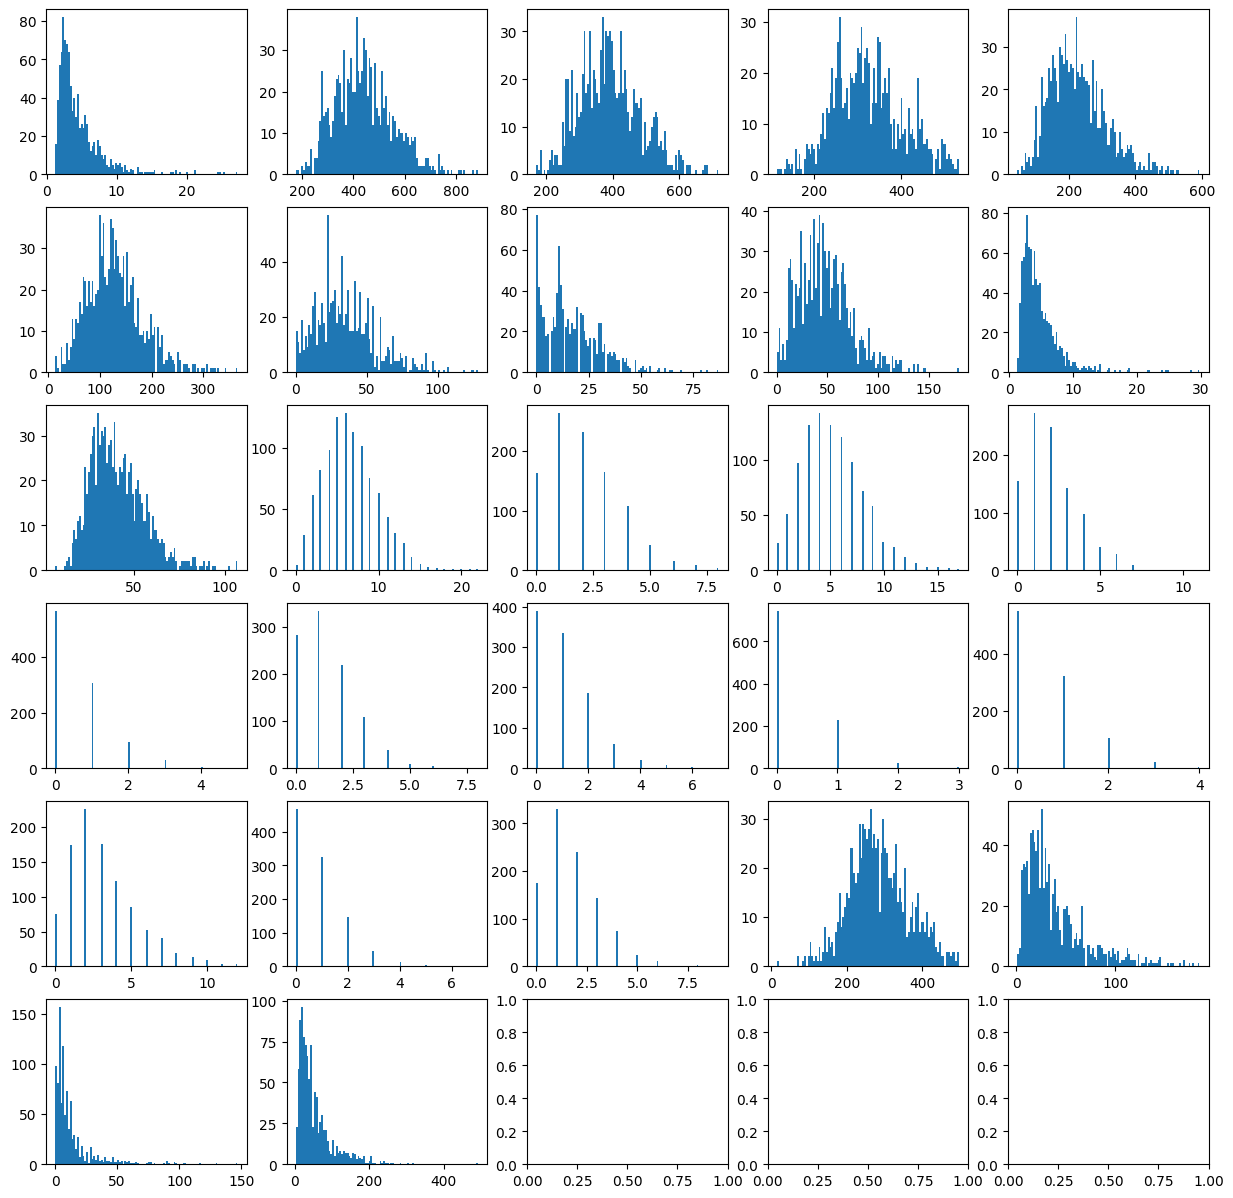

In [16]:
fig, axs = plt.subplots(6,5)
fig.set_size_inches(w=15, h=15)

axs = axs.flatten()
for i in range(27):
    axs[i].hist(sim_msas_stats.T[i], bins=100)
    # axs[i].set_xlim(0,1)
plt.show()


In [18]:
# EXPERIMENT 3 no ML
# sim.set_seed(42)

# REMOTE_SIMULATIONS = pathlib.Path("/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/Data/adequacy_experiments/experiment_3")

REMOTE_SIMULATIONS = sorted(REMOTE_SIMULATIONS.glob("*.pickle"))

NUMBER_OF_SAMPLES = 1000
sim_msas_stats = np.zeros(shape=(NUMBER_OF_SAMPLES,27))
pvals = np.zeros(shape=(NUM_EMPIRICAL_PARAMS,27))
tree_str = TREE_PATH.read_text()

for pidx, params in tqdm(enumerate(empirical_params)):
    sim.init_sim(*params)
    emp_msa = sim()
    emp_msa_realigned = rl.realign_sim_msa(emp_msa, tree_str, "AA")

    true_msa_stats = np.array(emp_msa_realigned.get_sum_stats())

    with open(REMOTE_SIMULATIONS[pidx], 'rb') as f:
        sim_msas_stats = pickle.load(f)

    for idx,stat in enumerate(SUMSTATS_LIST):
        p_val_x = empirical_p_values(sim_msas_stats.T[idx], true_msa_stats[idx], n=NUMBER_OF_SAMPLES)
        pvals[pidx,idx] = p_val_x


# experiment_3_pvals = pvals.copy()

0it [00:00, ?it/s]


IndexError: list index out of range

In [24]:
experiment_3_pvals = pvals.copy()

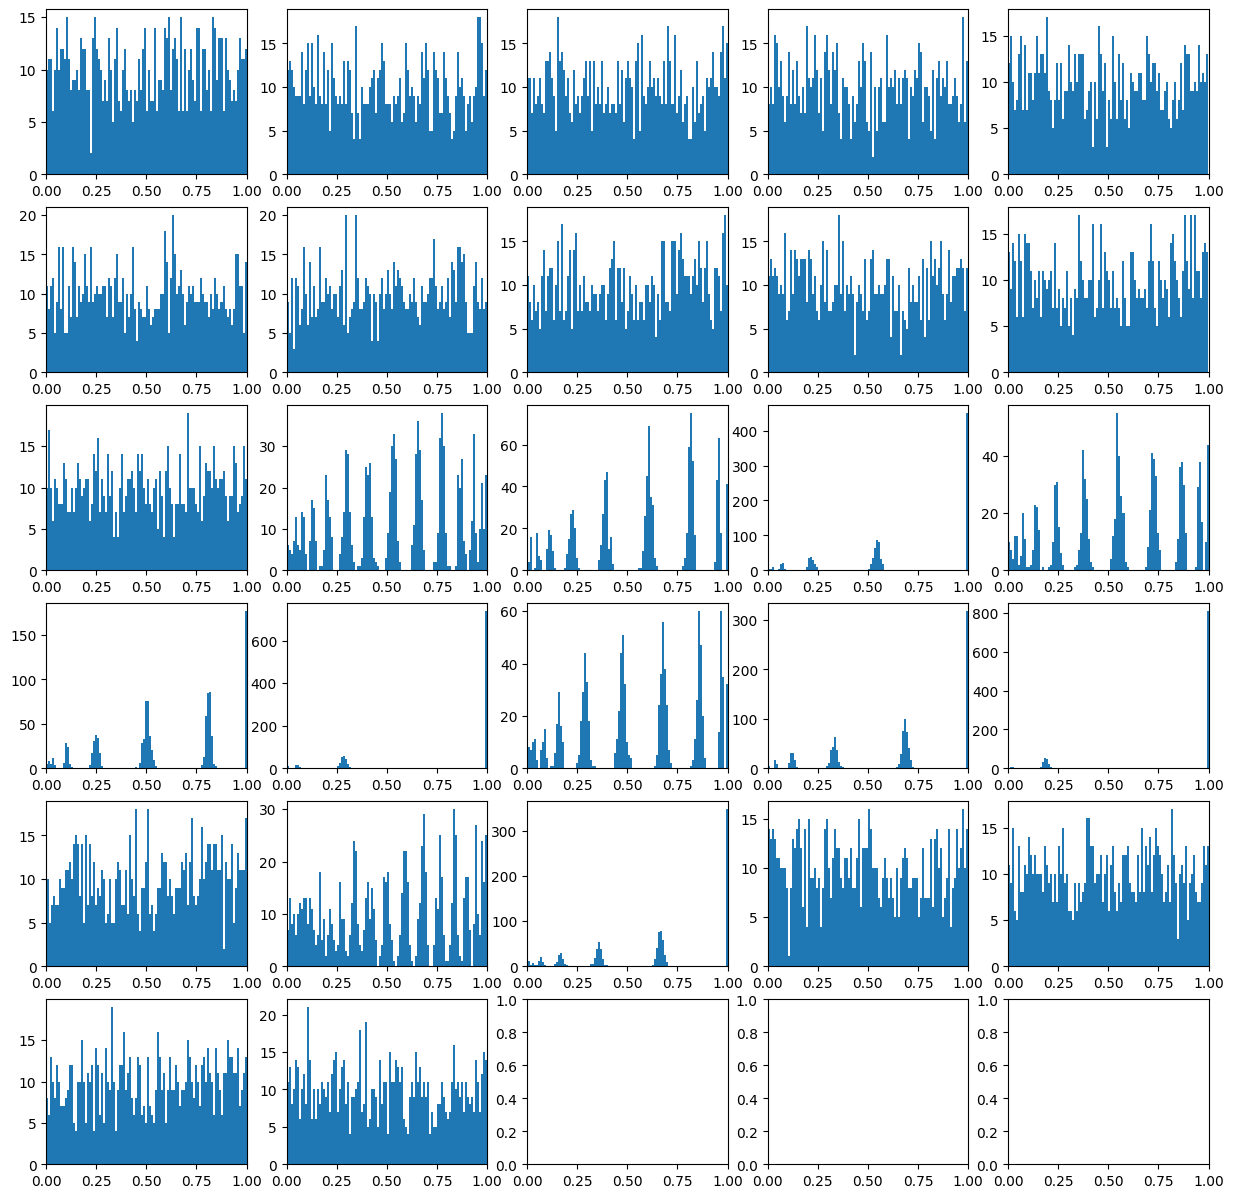

In [33]:
fig, axs = plt.subplots(6,5)
fig.set_size_inches(w=15, h=15)

axs = axs.flatten()

for i in range(27):
    axs[i].hist(experiment_3_pvals.T[i], bins=100)
    axs[i].set_xlim(0,1)
plt.show()

In [25]:
rejections_3 = sum(experiment_3_pvals < 0.05)/NUM_EMPIRICAL_PARAMS

for i in SUMSTATS_LIST:
    print(f"{i}", end="\t")
print()
for i in (sum(experiment_3_pvals < 0.05)/NUM_EMPIRICAL_PARAMS):
    print(f"{i:.1%}", end="\t")

SS_0	SS_1	SS_2	SS_3	SS_4	SS_5	SS_6	SS_7	SS_8	SS_9	SS_10	SS_11	SS_12	SS_13	SS_14	SS_15	SS_16	SS_17	SS_18	SS_19	SS_20	SS_21	SS_22	SS_23	SS_24	SS_25	SS_26	
4.9%	4.8%	4.9%	5.6%	4.2%	4.5%	5.6%	4.7%	4.2%	5.7%	5.3%	4.4%	3.8%	2.1%	5.4%	4.0%	2.7%	3.1%	3.7%	1.4%	5.3%	4.5%	2.4%	4.6%	3.7%	5.7%	4.7%	

In [26]:
import importlib
import realigner as rl
importlib.reload(rl)
# sim.set_seed(42)
#EXPERIMENT 3 with ML:
NUMBER_OF_SAMPLES = 1000
sim_msas_stats = np.zeros(shape=(NUMBER_OF_SAMPLES,32))
sim_msas_stats_corrected = np.zeros(shape=(NUMBER_OF_SAMPLES,27))
pvals = np.zeros(shape=(NUM_EMPIRICAL_PARAMS,27))
tree_str = TREE_PATH.read_text()


uncorrected_stats = np.zeros(shape=(500,32), dtype=object)
corrected_stats = np.zeros(shape=(500,27), dtype=object)

not_dist = [True,True, True, False, True, True]

correction_params = param_generator.get_random_sim(500)

for i, params in enumerate(correction_params):
    sim.init_sim(*params)
    uncorrected_msa = sim()
    corrected_msa = rl.realign_sim_msa(uncorrected_msa, tree_str, alphabet="AA")
    uncorrected_stats[i,:5] = empirical_params[0][not_dist]
    uncorrected_stats[i,5:] = uncorrected_msa.get_sum_stats()

    corrected_stats[i,:] = corrected_msa.get_sum_stats()

regressors, perf = rl.compute_regressors(uncorrected_stats, corrected_stats)
print("created regressors")


for pidx, params in tqdm(enumerate(empirical_params)):
    sim.init_sim(*params)
    emp_msa = sim()
    emp_msa_realigned = rl.realign_sim_msa(emp_msa, tree_str, "AA")

    true_msa_stats = np.array(emp_msa_realigned.get_sum_stats())
    
    for i in range(NUMBER_OF_SAMPLES):
        sim_msas_stats[i,:5] = params[not_dist]
        sim_msas_stats[i,5:] = sim().get_sum_stats()
    
    
    
    for idx,stat in enumerate(SUMSTATS_LIST):
        corrected_stat = regressors[idx].predict(sim_msas_stats)
        sim_msas_stats_corrected[:,idx] = corrected_stat
        p_val_x = empirical_p_values(corrected_stat, true_msa_stats[idx], n=NUMBER_OF_SAMPLES)
        pvals[pidx,idx] = p_val_x


# experiment_1_pvals = pvals.copy()

created regressors


1000it [11:12,  1.49it/s]


In [27]:
experiment_3ml_pvals = pvals.copy()

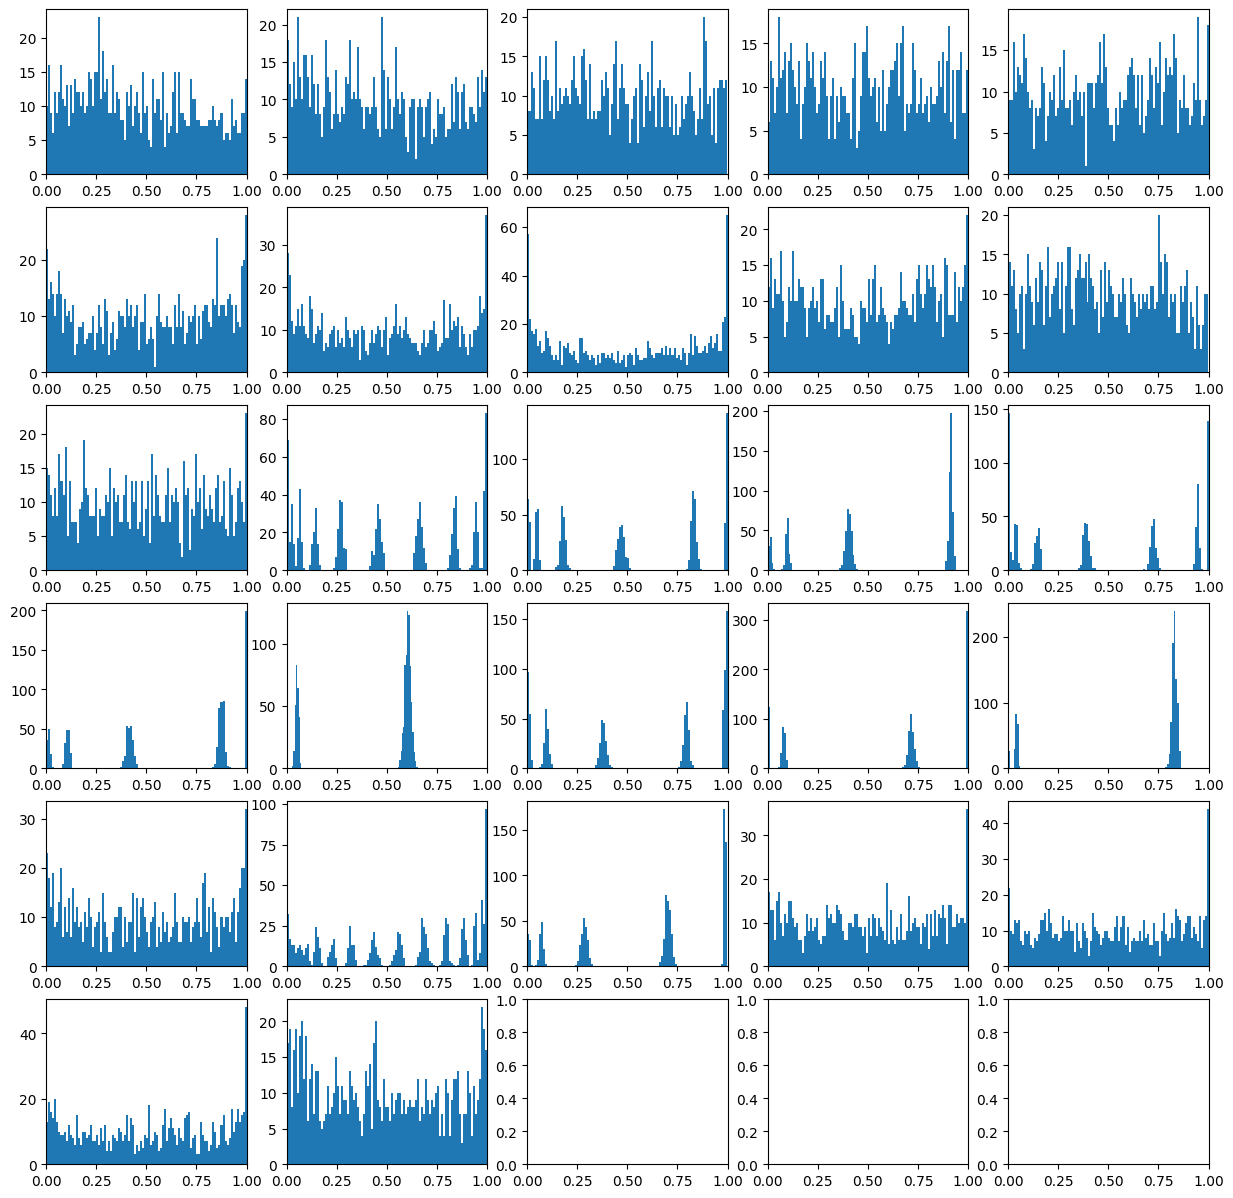

In [28]:
fig, axs = plt.subplots(6,5)
fig.set_size_inches(w=15, h=15)

axs = axs.flatten()

for i in range(27):
    axs[i].hist(experiment_3ml_pvals.T[i], bins=100)
    axs[i].set_xlim(0,1)
plt.show()

In [29]:
rejections_3ml = sum(experiment_3_pvals < 0.05)/NUM_EMPIRICAL_PARAMS

for i,j in zip(sum(experiment_3ml_pvals < 0.05)/NUM_EMPIRICAL_PARAMS, SUMSTATS_LIST):
    print(f"{j}: {i:.1%}")

SS_0: 5.3%
SS_1: 6.4%
SS_2: 4.7%
SS_3: 4.7%
SS_4: 5.4%
SS_5: 7.5%
SS_6: 8.3%
SS_7: 13.0%
SS_8: 6.1%
SS_9: 5.1%
SS_10: 5.9%
SS_11: 13.5%
SS_12: 16.9%
SS_13: 8.3%
SS_14: 25.8%
SS_15: 10.5%
SS_16: 15.2%
SS_17: 16.0%
SS_18: 12.6%
SS_19: 20.0%
SS_20: 8.0%
SS_21: 8.3%
SS_22: 6.6%
SS_23: 6.4%
SS_24: 6.6%
SS_25: 8.2%
SS_26: 7.9%


<BarContainer object of 27 artists>

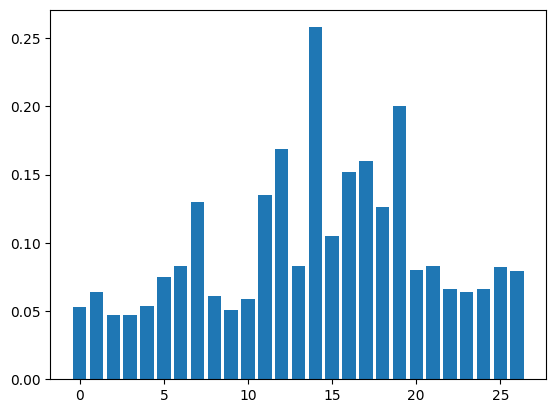

In [30]:
plt.bar(x=range(27), height=sum(experiment_3ml_pvals < 0.05)/NUM_EMPIRICAL_PARAMS)

In [32]:
import importlib
import realigner as rl
importlib.reload(rl)
# sim.set_seed(42)
#EXPERIMENT 4 with ML:

NUMBER_ABC_SIMS = 100000
ABC_THRESHOLD = 100
NUMBER_OF_SAMPLES = 1000

tree_str = TREE_PATH.read_text()


uncorrected_stats = np.zeros(shape=(500,32), dtype=object)
corrected_stats = np.zeros(shape=(500,27), dtype=object)

not_dist = [True,True, True, False, True, True]

correction_params = param_generator.get_random_sim(500)

for i, params in enumerate(correction_params):
    sim.init_sim(*params)
    uncorrected_msa = sim()
    corrected_msa = rl.realign_sim_msa(uncorrected_msa, tree_str, alphabet="AA")
    uncorrected_stats[i,:5] = empirical_params[0][not_dist]
    uncorrected_stats[i,5:] = uncorrected_msa.get_sum_stats()

    corrected_stats[i,:] = corrected_msa.get_sum_stats()

regressors, perf = rl.compute_regressors(uncorrected_stats, corrected_stats)
print("created regressors")


sim_msas_abc = np.zeros(shape=(NUMBER_ABC_SIMS,32))
sim_msas_abc_corrected = np.zeros(shape=(NUMBER_ABC_SIMS,27))



sim_params = param_generator.get_random_sim(NUMBER_ABC_SIMS)

for i,params in enumerate(sim_params):
    sim.init_sim(*params)
    sim_msa = sim()
    sim_msas_abc[i,:5] = params[not_dist]
    sim_msas_abc[i,5:] = sim().get_sum_stats()

for idx,stat in enumerate(SUMSTATS_LIST):
    corrected_stat = regressors[idx].predict(sim_msas_abc)
    sim_msas_abc_corrected[:,idx] = corrected_stat

print("finished simulating and correction")

cov = np.cov(sim_msas_abc_corrected.T)
cov = cov + np.eye(len(cov))*1e-4
inv_covmat = np.linalg.inv(cov)

created regressors
finished simulating and correction


In [34]:
sim_msas_stats = np.zeros(shape=(NUMBER_OF_SAMPLES,27))
pvals = np.zeros(shape=(NUM_EMPIRICAL_PARAMS,27))


for pidx, params in tqdm(enumerate(empirical_params)):
    sim.init_sim(*params)
    emp_msa = sim()
    emp_msa_realigned = rl.realign_sim_msa(emp_msa, tree_str, "AA")

    true_msa_stats = np.array(emp_msa_realigned.get_sum_stats())

    u_minus_v = true_msa_stats-sim_msas_abc_corrected
    left = np.dot(u_minus_v, inv_covmat)
    all_distances = np.sqrt(np.sum(u_minus_v*left, axis=1))
    

    top_indexes = np.argsort(all_distances)[:ABC_THRESHOLD]
    sampled_indx = np.random.choice(top_indexes, size=NUMBER_OF_SAMPLES)
    sampled_params = sim_params[sampled_indx]

    for i,params_sim in enumerate(sampled_params):
        sim.init_sim(*params_sim)
        sim_msa = sim()
        realigned_sim_msa = rl.realign_sim_msa(sim_msa, tree_str, "AA")

        sim_msas_stats[i,:] = realigned_sim_msa.get_sum_stats()
    
    for idx,stat in enumerate(SUMSTATS_LIST):
        p_val_x = empirical_p_values(sim_msas_stats.T[idx], true_msa_stats[idx], n=NUMBER_OF_SAMPLES)
        pvals[pidx,idx] = p_val_x    
    

1it [02:08, 128.94s/it]


KeyboardInterrupt: 

In [9]:
current_data_dir = WORKING_DIR / "experiment_4"
current_file = next(current_data_dir.glob("*.pickle"))

StopIteration: 

In [42]:
with open(current_file, 'rb') as f:
    a = pickle.load(f)

In [12]:
# REMOTE_SIMULATIONS = pathlib.Path("/run/user/1000/gvfs/sftp:host=power.tau.ac.il,user=elyawygoda/groups/pupko/elyawygoda/Data/adequacy_experiments/experiment_4")
REMOTE_SIMULATIONS = pathlib.Path("/run/user/1000/kio-fuse-LyzJYs/sftp/elyawygoda@powerlogin.tau.ac.il:22/groups/pupko/elyawygoda/Data/adequacy_experiments/experiment_4")
REMOTE_SIMULATIONS = sorted(REMOTE_SIMULATIONS.glob("*.pickle"))

NUMBER_OF_SAMPLES = 1000
sim_msas_stats = np.zeros(shape=(NUMBER_OF_SAMPLES,27))
pvals = np.zeros(shape=(NUM_EMPIRICAL_PARAMS,27))

for i in tqdm(range(NUM_EMPIRICAL_PARAMS)):
    with open(REMOTE_SIMULATIONS[i], 'rb') as f:
        pvals[i] =  pickle.load(f)
    



100%|██████████| 1000/1000 [08:22<00:00,  1.99it/s]


In [15]:
experiment_4_pvals = pvals.copy()

In [16]:
rejections_4 = sum(experiment_4_pvals < 0.05)/NUM_EMPIRICAL_PARAMS

for i,j in zip(rejections_4, SUMSTATS_LIST):
    print(f"{j}: {i:.1%}")

SS_0: 3.0%
SS_1: 9.6%
SS_2: 10.4%
SS_3: 2.1%
SS_4: 2.1%
SS_5: 0.2%
SS_6: 1.5%
SS_7: 3.2%
SS_8: 9.2%
SS_9: 3.7%
SS_10: 2.9%
SS_11: 0.9%
SS_12: 2.8%
SS_13: 0.1%
SS_14: 2.9%
SS_15: 2.9%
SS_16: 0.1%
SS_17: 5.2%
SS_18: 4.9%
SS_19: 0.7%
SS_20: 3.1%
SS_21: 5.7%
SS_22: 2.0%
SS_23: 0.1%
SS_24: 6.3%
SS_25: 10.6%
SS_26: 10.8%


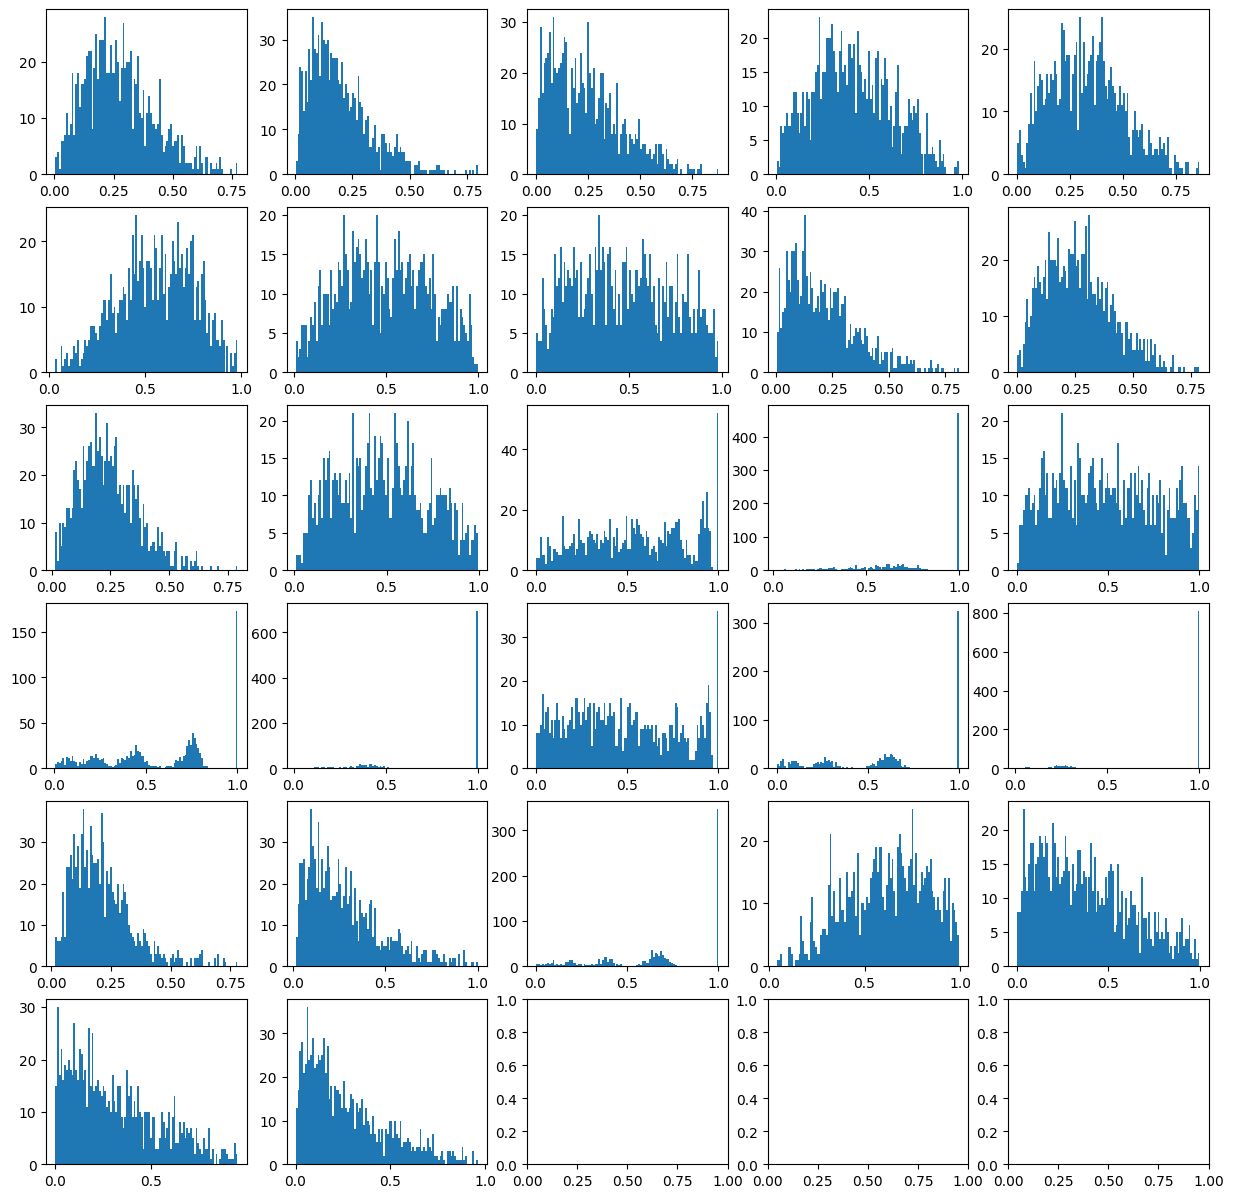

In [17]:
fig, axs = plt.subplots(6,5)
fig.set_size_inches(w=15, h=15)

axs = axs.flatten()

for i in range(27):
    axs[i].hist(experiment_4_pvals.T[i], bins=100)
    # axs[i].set_xlim(0,1)
plt.show()

In [68]:
import importlib
import sim_creator
import numpy as np
from matplotlib import pyplot as plt
importlib.reload(sim_creator)

param_gen = sim_creator.SimConfig(indel_model="sim")

In [76]:
params = param_gen.get_random_sim(600000)

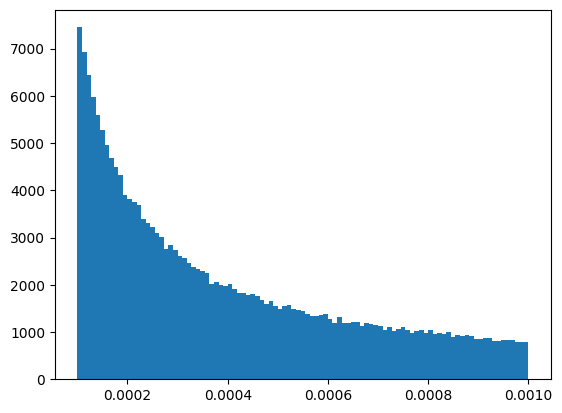

In [77]:
plt.hist(params.T[2], bins=np.linspace(0.0001,0.001, 100))
plt.show()

In [26]:
from scipy.stats import distributions

In [48]:
logdist = distributions.loguniform(0.0001,0.1)


In [55]:
distributions.loguniform.rvs(0.0001,0.1,size=100)

array([0.00019231, 0.01598523, 0.00104513, 0.00815929, 0.00119442,
       0.00023014, 0.00534368, 0.01929875, 0.09133021, 0.03512403,
       0.00216281, 0.00017178, 0.00382504, 0.01104288, 0.0009556 ,
       0.02425427, 0.04598421, 0.0031221 , 0.02623488, 0.0045391 ,
       0.00092612, 0.00415909, 0.07414289, 0.00074059, 0.00480221,
       0.00352305, 0.00043644, 0.00405418, 0.00024427, 0.0341155 ,
       0.00098832, 0.00376625, 0.00106445, 0.00060707, 0.00089859,
       0.04770314, 0.07844599, 0.01878765, 0.00012007, 0.00952011,
       0.00046377, 0.00190697, 0.00011309, 0.00332104, 0.0004254 ,
       0.0069778 , 0.00010348, 0.00026691, 0.01101136, 0.01001059,
       0.00444259, 0.00095164, 0.00024355, 0.00512774, 0.06777386,
       0.0911978 , 0.0002342 , 0.00110997, 0.06087467, 0.03366538,
       0.07547971, 0.00155537, 0.0265081 , 0.01813228, 0.05680949,
       0.03321321, 0.01432956, 0.00024649, 0.00493128, 0.00055583,
       0.0058702 , 0.00034255, 0.04547338, 0.00013309, 0.00112

In [49]:
log_test = logdist.rvs(500000)

(array([6259., 5838., 5323., 5099., 4758., 4469., 4178., 4011., 3711.,
        3491., 3359., 3251., 3094., 2921., 2802., 2809., 2631., 2515.,
        2390., 2268., 2324., 2193., 2089., 2068., 2025., 2048., 2001.,
        1848., 1871., 1801., 1755., 1733., 1638., 1606., 1576., 1523.,
        1457., 1433., 1475., 1466., 1400., 1389., 1380., 1322., 1309.,
        1288., 1218., 1275., 1219., 1228., 1115., 1176., 1138., 1190.,
        1124., 1073., 1048., 1087., 1056., 1095., 1009., 1010.,  963.,
         941.,  895.,  933.,  917.,  956.,  907.,  913.,  916.,  880.,
         870.,  888.,  859.,  842.,  727.,  824.,  860.,  813.,  760.,
         782.,  763.,  822.,  718.,  754.,  733.,  680.,  743.,  756.,
         673.,  706.,  729.,  684.,  660.,  699.,  683.,  669.,  696.]),
 array([0.0001    , 0.00010909, 0.00011818, 0.00012727, 0.00013636,
        0.00014545, 0.00015455, 0.00016364, 0.00017273, 0.00018182,
        0.00019091, 0.0002    , 0.00020909, 0.00021818, 0.00022727,
        0.000

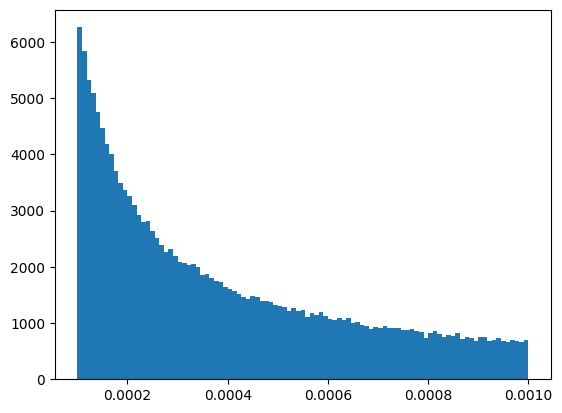

In [51]:
plt.hist(log_test, bins=np.linspace(0.0001,0.001,100))

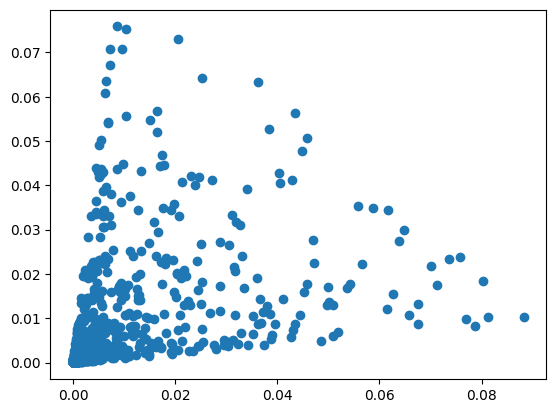

In [35]:
x = 10**np.random.uniform(-4,-1, 1000)
y = 10**np.random.uniform(-1.0,1.0, 1000)

r_d = x/(y+1)
r_i = x - r_d

plt.scatter(r_d, r_i, marker='o')


In [1]:
import pathlib
WORKING_DIR = pathlib.Path("/home/elyawy/Documents/PhD/length distributions/assets/")
WORKING_DIR = next(WORKING_DIR.glob("*.tree"))
# /sftp/elyawygoda@powerlogin.tau.ac.il:22/groups/pupko/elyawygoda/length_distributions/all_outputs/results
# RESULTS_PATH = pathlib.Path("/run/user/1000/kio-fuse-rnNRwy/sftp/elyawygoda@powerlogin.tau.ac.il:22/groups/pupko/elyawygoda/length_distributions/all_outputs/results").resolve() # sys.argv[2]

WORKING_DIR.exists()

True

In [18]:
from ete3 import Tree, TreeStyle
t = Tree(str(WORKING_DIR))

ts = TreeStyle()
ts.show_leaf_name = True
ts.scale =  (2000) # 120 pixels per branch length unit
t.render("out.png", tree_style=ts,dpi=1500)

{'nodes': [[0.5, 185.203125, 4.5, 189.203125, 0, None],
  [170.351, 138.625, 174.351, 142.625, 1, None],
  [208.2768, 106.25, 212.2768, 110.25, 2, None],
  [251.1236, 77.5, 255.1236, 81.5, 3, None],
  [304.5032, 44.0, 308.5032, 48.0, 4, None],
  [422.6304, 15.0, 426.6304, 19.0, 5, None],
  [443.52102, 7.0, 447.52102, 11.0, 6, None],
  [442.88452, 23.0, 446.88452, 27.0, 7, None],
  [311.23336, 73.0, 315.23336, 77.0, 8, None],
  [384.99576, 59.0, 388.99576, 63.0, 9, None],
  [412.28936, 47.0, 416.28936, 51.0, 10, None],
  [441.95176, 39.0, 445.95176, 43.0, 11, None],
  [508.56816, 55.0, 512.56816, 59.0, 12, None],
  [487.77936, 71.0, 491.77936, 75.0, 13, None],
  [398.29356, 87.0, 402.29356, 91.0, 14, None],
  [278.7198, 111.0, 282.7198, 115.0, 15, None],
  [313.0212, 103.0, 317.0212, 107.0, 16, None],
  [303.1326, 119.0, 307.1326, 123.0, 17, None],
  [659.2928, 135.0, 663.2928, 139.0, 18, None],
  [193.2222, 171.0, 197.2222, 175.0, 19, None],
  [222.8484, 159.0, 226.8484, 163.0, 20, Non